In [1]:
# Try to flatten the images first

import os
import numpy as np
from PIL import Image 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [17]:
import cv2
import os

# Specify the directory containing images
image_folder = '20241009_image_input_60_1'

# Loop through each file in the directory
for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Add other formats if needed
        # Read the image file
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = img > 32
        img = img.astype(np.uint8) * 255
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        print(f"Images shape: {img.shape}")
        # Check if the image is loaded properly
        if img is None:
            print(f"Failed to load {filename}")
            continue

        # Check the number of channels
        if len(img.shape) == 2:
            print(f"{filename}: Grayscale")
        elif len(img.shape) == 3 and img.shape[2] == 3:
            print(f"{filename}: RGB")
            print(f"Images shape: {img.shape}")
        else:
            print(f"{filename}: Unknown format")
        print(img)
        
    break

Images shape: (96, 180)
67451_28_75294_1999-08-30_0.csv.jpeg: Grayscale
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]
 [  0 255   0 ...   0 255   0]]


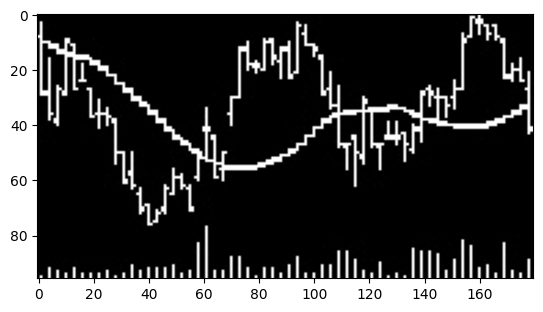

In [14]:
for filename in os.listdir(image_folder):
    img_path = os.path.join(image_folder, filename)
    img = mpimg.imread(img_path)
    plt.figure()
    plt.imshow(img, cmap = "gray", vmin = 0, vmax = 255)
    break

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm

In [3]:
# We write a function to convert the images folder to .dat type
def images_to_dat(images_folder, output_file):
    with open(output_file, "wb") as dat_file:
        for filename in sorted([f for f in os.listdir(images_folder) if f != "output.csv"], key = lambda x: int(x.split('_')[0])):
        # for filename in os.listdir(images_folder):
            if filename.endswith(".jpeg"):
            # Read the image file
                img_path = os.path.join(images_folder, filename)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load {filename}")
                    continue 
                img = img > 32
                img = img.astype(np.uint8) * 255
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                img_array = np.array(img)

                # Flatten the image and convert to bytes, for easier storage
                image_bytes = img_array.flatten().tobytes()

                # Write the image data and store that in .dat file
                dat_file.write(image_bytes)

In [4]:
# Use the function
images_to_dat("training_data", "training_data.dat")
images_to_dat("validation_data", "validation_data.dat")

In [5]:
# We then create an array of images
# This is a breakthrough, at least for me, since I cannot do anything to store a large amount like that
# to a list, until I find np.memmap
training_data = []
training_data.append(np.memmap("training_data.dat", dtype = np.uint8, mode = 'r').reshape(
                        (-1, 96, 180))) # since it is 96 x 180 images
training_data = np.concatenate(training_data)
print(training_data.shape)

(86751, 96, 180)


In [6]:
# Similarly, for validation_data
validation_data = []
validation_data.append(np.memmap("validation_data.dat", dtype = np.uint8, mode = 'r').reshape(
    (-1, 96, 180)))
validation_data = np.concatenate(validation_data)
print(validation_data.shape)

(37179, 96, 180)


In [7]:
# For output

def extract_outputs(images_folder):
    outputs = []

    for filename in sorted([f for f in os.listdir(images_folder) if f != "output.csv"], key = lambda x: int(x.split('_')[0])):
        if filename.endswith('.jpeg'):  # Adjust based on file extension
            # Split the filename to extract the output value
            parts = filename.split('_')
            if len(parts) > 4:  # Ensure there are enough parts
                output_value = parts[-1].split('.')[0]  # Get the last part before the extension
                outputs.append(int(output_value))  # Convert to integer and store
            
    return outputs

def save_outputs_to_csv(images_folder, output_file):
    outputs = extract_outputs(images_folder)
    
    # Create the DataFrame
    df = pd.DataFrame({'output': outputs})
    
    # Save DataFrame as a Feather file
    df.to_csv(output_file)

In [8]:
save_outputs_to_csv("training_data", "training_outputs.csv")
save_outputs_to_csv("validation_data", "validation_outputs.csv")

In [9]:
training_outputs = pd.read_csv("training_outputs.csv")
training_outputs = training_outputs.drop(training_outputs.columns[0], axis = 1)
print(f"Training Label Shape: {training_outputs.shape}")
validation_outputs = pd.read_csv("validation_outputs.csv")
validation_outputs = validation_outputs.drop(validation_outputs.columns[0], axis = 1)
print(f"Validation Label Shape: {validation_outputs.shape}")

Training Label Shape: (86751, 1)
Validation Label Shape: (37179, 1)


In [10]:
# Change both to numpy array
training_outputs = training_outputs.to_numpy()
validation_outputs = validation_outputs.to_numpy()

In [13]:
print(torch.__version__)

2.2.2


In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (5, 3), stride = (3, 1), dilation = (2, 1), padding = (12, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),
            nn.MaxPool2d((2, 1), stride = (2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = (5,3), stride = (3,1), dilation = (2,1), padding = (12,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),
            nn.MaxPool2d((2, 1), stride = (2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = (5,3), stride = (3,1), dilation = (2,1), padding = (12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),
            nn.MaxPool2d((2, 1), stride = (2, 1)),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = (5,3), stride = (3,1), dilation = (2,1), padding = (12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.01, inplace = True),
            nn.MaxPool2d((2, 1), stride = (2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(184320, 2),
        )
        self.softmax = nn.Softmax(dim=1)
       
    def forward(self, x):
        x = x.reshape(-1, 1, 64, 60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.reshape(-1, 184320)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [38]:
# Create a class for storing dataset

class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
    
    def __len__(self):
        return self.len 

    def __getitem__(self, index):
        return self.img[index], self.label[index]

In [39]:
# Create the dataset

training_dataset = MyDataset(training_data, training_outputs)
validation_dataset = MyDataset(validation_data, validation_outputs)

In [36]:
print(validation_outputs.shape)

(37179, 1)


In [40]:
# Create dataloader
training_dataloader = DataLoader(training_dataset, batch_size = 128, shuffle = True, pin_memory = True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 128, shuffle = False, pin_memory = True)

In [41]:
# Then, we initialize weights for models

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [49]:
# Need to work on more

device = 'cuda' if use_gpu else 'cpu'
def train_loop(dataloader, net, loss_fn, optimizer):
    
    running_loss = 0.0
    current = 0
    net.train()
    
    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y.long())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
            current += len(X)
            t.set_postfix({'running_loss':running_loss})
    
    return running_loss